# Installing Dependencies

In [24]:
pip install numpy pandas scikit-learn matplotlib tensorflow seaborn ace-tools

Note: you may need to restart the kernel to use updated packages.


# Importing Libraries

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

# Load and Preprocess the Dataset

In [6]:
# Load dataset
df = pd.read_csv("sessions_enriched_old.csv")

# Drop non-informative or high-missing columns
cols_to_drop = [
    'Start Time', 'End Time', 'Source', 'Destination', 'Resolved Hostname',
    'City', 'Organization', 'Region', 'TLS Session ID', 'TLS ALPN', 'TLS Supported Groups',
    'TLS EC Point Formats', 'TLS Key Share Group'
]
df_cleaned = df.drop(columns=cols_to_drop)

# Fill missing values
df_cleaned.fillna("unknown", inplace=True)

# Separate numeric and categorical columns
numerical_cols = df_cleaned.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = df_cleaned.select_dtypes(include=['object']).columns.tolist()

# One-hot encode categoricals
df_encoded = pd.get_dummies(df_cleaned, columns=categorical_cols)

# Normalize numeric features
scaler = MinMaxScaler()
df_encoded[numerical_cols] = scaler.fit_transform(df_encoded[numerical_cols])


/var/folders/tn/v8lfx2sn4s3fb70tbh_n49kw0000gn/T/ipykernel_23116/4228322704.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'unknown' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_cleaned.fillna("unknown", inplace=True)


# Build and Train Autoencoder

In [7]:
# Define Autoencoder
input_dim = df_encoded.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(128, activation='relu')(input_layer)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
output_layer = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train
history = autoencoder.fit(
    df_encoded, df_encoded,
    epochs=20,
    batch_size=64,
    shuffle=True,
    validation_split=0.1,
    verbose=1
)

Epoch 1/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1270 - val_loss: 0.0035
Epoch 2/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0036 - val_loss: 0.0035
Epoch 3/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 4/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0034 - val_loss: 0.0031
Epoch 5/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 6/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 7/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 8/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 9/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 10/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0021 - val_loss: 0.0024
Epoch 11/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 12/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0020 - val_lo

# Evaluate and Detect Anomalies

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step


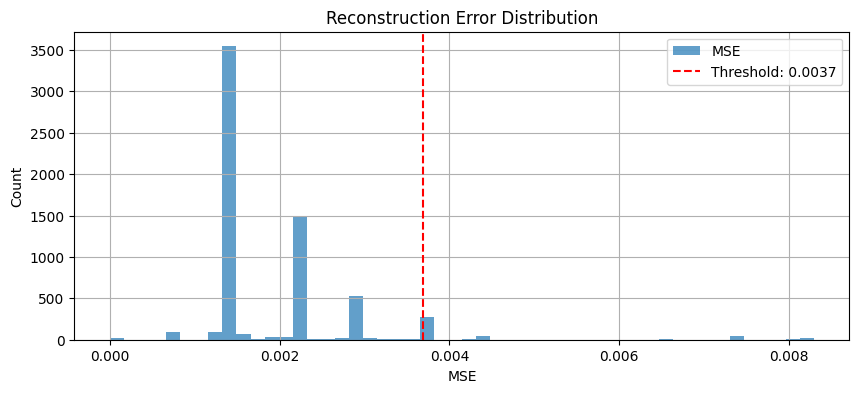

Total anomalies detected: 321 / 6405


In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Reconstruct and calculate error
reconstructed = autoencoder.predict(df_encoded)
mse = np.mean(np.power(df_encoded - reconstructed, 2), axis=1)

# Threshold based on 95th percentile
threshold = np.percentile(mse, 95)
anomalies = mse > threshold

# Visualize reconstruction error
plt.figure(figsize=(10, 4))
plt.hist(mse, bins=50, alpha=0.7, label='MSE')
plt.axvline(threshold, color='r', linestyle='--', label=f'Threshold: {threshold:.4f}')
plt.title("Reconstruction Error Distribution")
plt.xlabel("MSE")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.show()

# Anomaly count
print(f"Total anomalies detected: {np.sum(anomalies)} / {len(mse)}")


# Save Results

In [9]:
# Attach anomaly labels to original DataFrame
df['Reconstruction_Error'] = mse
df['Anomaly'] = anomalies.astype(int)

# Save to CSV
df.to_csv("tls_anomaly_output.csv", index=False)
print("Anomaly results saved to tls_anomaly_output.csv")

Anomaly results saved to tls_anomaly_output.csv


# Investigate Top Anomalies

In [12]:
# Sort the sessions by reconstruction error (descending)
top_anomalies = df[df['Anomaly'] == 1].sort_values(by='Reconstruction_Error', ascending=False)

# Annotate reason for anomaly
def get_reason(row):
    if row['Packet Count'] <= 2 and row['Duration (s)'] == 0:
        return "Likely handshake failure or dropped connection"
    if pd.isna(row['TLS Version']):
        return "Missing TLS metadata"
    if row['SNI_TLD'] == 'unknown':
        return "No Server Name Indication (SNI)"
    if row['Country'] == 'Unknown':
        return "Geolocation missing"
    return "Unusual behavior"

top_anomalies['Reason'] = top_anomalies.apply(get_reason, axis=1)

# Display the top 10 anomalies with reasons
columns_to_inspect = [
    'Reconstruction_Error', 'Country', 'City', 'Duration (s)', 'Packet Count',
    'TLS Version', 'Cipher_Strength', 'Resolved Hostname', 'SNI_TLD', 'Reason'
]

print("🔍 Top 10 Anomalous TLS Sessions with Reasons:")
display(top_anomalies[columns_to_inspect].head(10))


🔍 Top 10 Anomalous TLS Sessions with Reasons:


,Reconstruction_Error,Country,City,Duration (s),Packet Count,TLS Version,Cipher_Strength,Resolved Hostname,SNI_TLD,Reason
Timestamp,,,,,,,,,,
2025-05-29 04:18:49.345696926,0.008294,India,Hyderabad,5.024,2,NaN,unknown,Unknown,unknown,Missing TLS metadata
2025-05-28 05:10:35.950495005,0.008246,United States,Council Bluffs,5.207,15,NaN,unknown,178.238.223.35.bc.googleusercontent.com,unknown,Missing TLS metadata
2025-05-29 04:17:02.203127146,0.008149,Unknown,Unknown,0.000,1,NaN,unknown,Private IP,unknown,Likely handshake failure or dropped connection
2025-05-28 05:12:16.224364042,0.008149,Unknown,Unknown,0.000,1,NaN,unknown,Private IP,unknown,Likely handshake failure or dropped connection
2025-05-28 05:09:46.268251896,0.008149,Unknown,Unknown,0.000,1,NaN,unknown,Private IP,unknown,Likely handshake failure or dropped connection
2025-05-29 04:17:16.501769066,0.008149,Unknown,Unknown,0.000,1,NaN,unknown,Private IP,unknown,Likely handshake failure or dropped connection
2025-05-28 05:09:59.125817060,0.008149,Unknown,Unknown,0.000,1,NaN,unknown,Private IP,unknown,Likely handshake failure or dropped connection
2025-05-29 04:17:22.785379171,0.008149,Unknown,Unknown,0.000,1,NaN,unknown,Private IP,unknown,Likely handshake failure or dropped connection
2025-05-29 04:17:14.743887901,0.008149,Unknown,Unknown,0.000,1,NaN,unknown,Private IP,unknown,Likely handshake failure or dropped connection


# Visualize Anomaly Detection Results

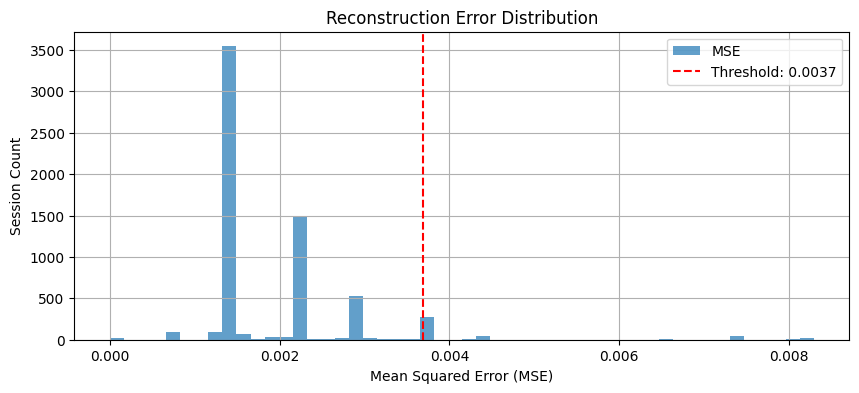

/Users/ragav/venvs/tf-env/lib/python3.10/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/ragav/venvs/tf-env/lib/python3.10/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/ragav/venvs/tf-env/lib/python3.10/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/ragav/venvs/tf-env/lib/python3.10/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/ragav/venvs/tf-env/lib/python3.10/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/ragav/venvs/tf-env/lib/python3.10/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/ragav/venvs

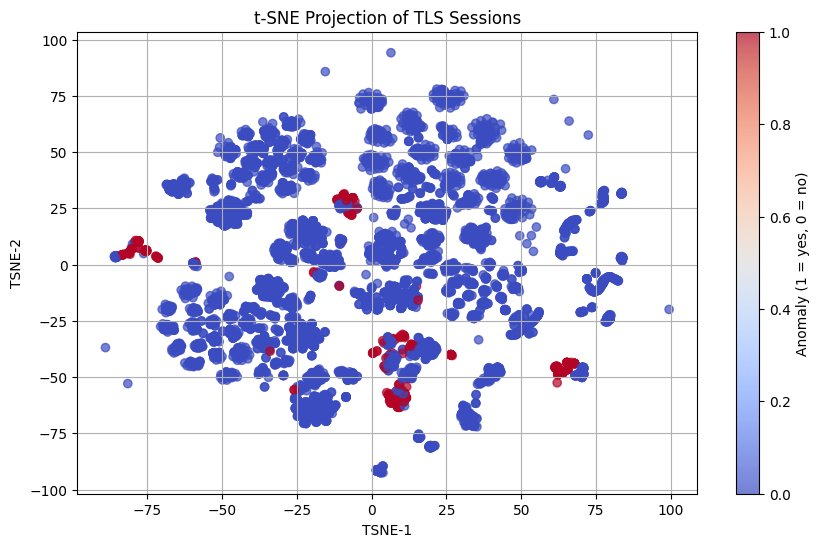

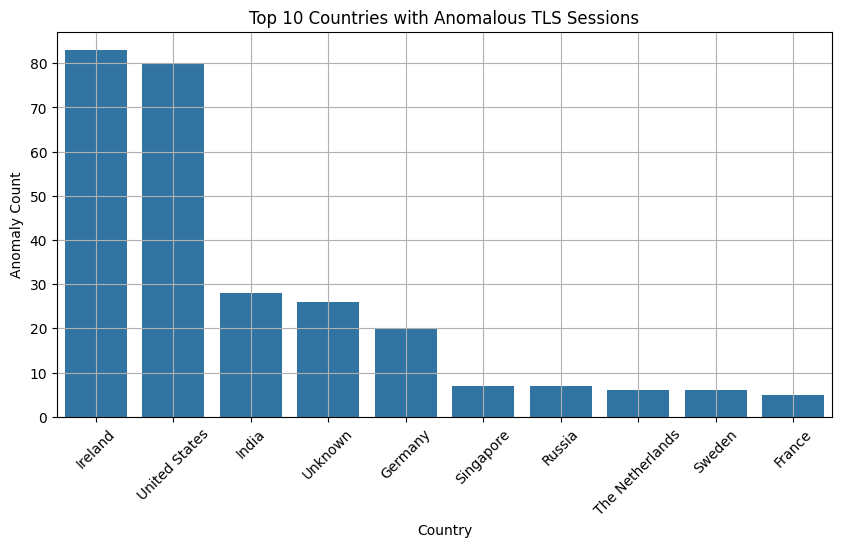

/var/folders/tn/v8lfx2sn4s3fb70tbh_n49kw0000gn/T/ipykernel_23116/2071205956.py:47: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  anomaly_timeline = df[df['Anomaly'] == 1].resample('H').size()


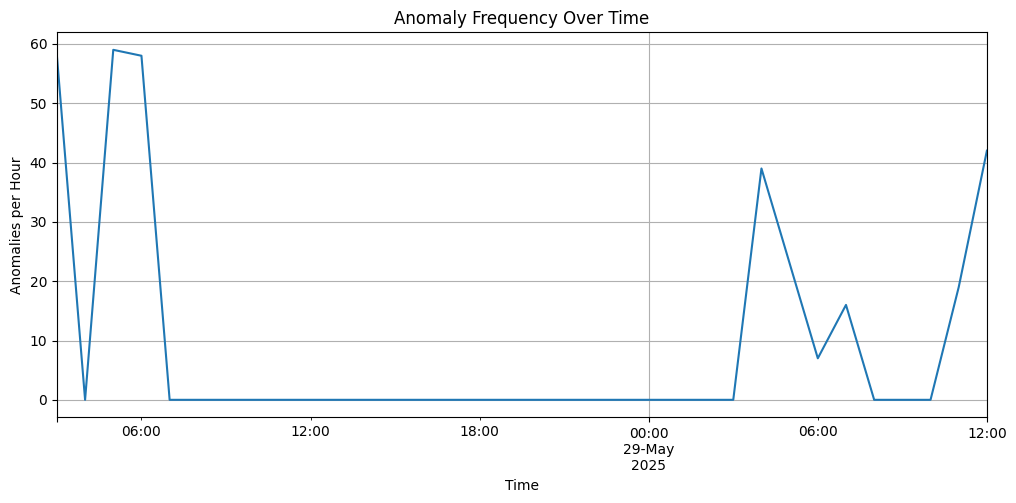

In [11]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd

# 1. Histogram of Reconstruction Errors
plt.figure(figsize=(10, 4))
plt.hist(mse, bins=50, alpha=0.7, label='MSE')
plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold: {threshold:.4f}')
plt.title("Reconstruction Error Distribution")
plt.xlabel("Mean Squared Error (MSE)")
plt.ylabel("Session Count")
plt.legend()
plt.grid(True)
plt.show()

# 2. t-SNE Projection of High-Dimensional Sessions
tsne = TSNE(n_components=2, random_state=42)
df_tsne = tsne.fit_transform(df_encoded)

plt.figure(figsize=(10, 6))
plt.scatter(df_tsne[:, 0], df_tsne[:, 1], c=anomalies, cmap='coolwarm', alpha=0.7)
plt.title("t-SNE Projection of TLS Sessions")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.colorbar(label="Anomaly (1 = yes, 0 = no)")
plt.grid(True)
plt.show()

# 3. Top Countries with Anomalies
if 'Country' in df.columns:
    country_anomaly_counts = df[anomalies]['Country'].value_counts().head(10)

    plt.figure(figsize=(10, 5))
    sns.barplot(x=country_anomaly_counts.index, y=country_anomaly_counts.values)
    plt.title("Top 10 Countries with Anomalous TLS Sessions")
    plt.ylabel("Anomaly Count")
    plt.xlabel("Country")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

# 4. Anomalies Over Time (if timestamp is available)
if 'Start Time' in df.columns:
    df['Timestamp'] = pd.to_datetime(df['Start Time'], unit='s')
    df.set_index('Timestamp', inplace=True)
    anomaly_timeline = df[df['Anomaly'] == 1].resample('H').size()

    plt.figure(figsize=(12, 5))
    anomaly_timeline.plot()
    plt.title("Anomaly Frequency Over Time")
    plt.ylabel("Anomalies per Hour")
    plt.xlabel("Time")
    plt.grid(True)
    plt.show()


In [ ]:
import pandas as pd
from sklearn.ensemble import IsolationForest
import joblib

class AnomalyDetector:
    def __init__(self, contamination=0.01):
        self.model = IsolationForest(contamination=contamination, random_state=42)

    def train(self, df):
        features = self._extract_features(df)
        self.model.fit(features)
        joblib.dump(self.model, '/mnt/data/isolation_model.pkl')  # Save model

    def predict(self, df):
        features = self._extract_features(df)
        predictions = self.model.predict(features)
        df['is_anomaly'] = (predictions == -1)
        return df[df['is_anomaly']]

    def _extract_features(self, df):
        exclude = ['timestamp', 'label']
        df_clean = df.drop(columns=[col for col in exclude if col in df.columns], errors='ignore')
        df_numeric = df_clean.select_dtypes(include='number')
        return df_numeric.fillna(df_numeric.mean())  # Impute NaNs

# Example usage:
if __name__ == "__main__":
    df = pd.read_csv('/mnt/data/sessions_enriched_old.csv')
    detector = AnomalyDetector()
    detector.train(df)
    anomalies = detector.predict(df)
    anomalies.to_csv('/mnt/data/anomalies_detected.csv', index=False)
    print(anomalies.head())


ModuleNotFoundError: No module named 'ace_tools'